In [1]:
import pandas as pd
import numpy as np
# from m4_feats_functions import *
# from m7_utils import *
# from m5_models import *
from m3_model_params import lgb_params_2 as lgbm_params
from m3_model_params import xgb_params_2 as xgb_params
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import PowerTransformer, MinMaxScaler, StandardScaler
from m3_model_params import non_important_feats

In [2]:
""" INPUT_DIR = 'kaggle/input/linking-writing-processes-to-writing-quality'
FEAT_STORE_DIR = 'feat_store_combined'
train_logs = pd.read_csv(f'{INPUT_DIR}/train_logs.csv')
train_scores = pd.read_csv(f'{INPUT_DIR}/train_scores.csv')
test_logs = pd.read_csv(f'{INPUT_DIR}/test_logs.csv')
ss_df = pd.read_csv(f'{INPUT_DIR}/sample_submission.csv')

# logs = pd.concat([train_logs, test_logs], axis=0) """

" INPUT_DIR = 'kaggle/input/linking-writing-processes-to-writing-quality'\nFEAT_STORE_DIR = 'feat_store_combined'\ntrain_logs = pd.read_csv(f'{INPUT_DIR}/train_logs.csv')\ntrain_scores = pd.read_csv(f'{INPUT_DIR}/train_scores.csv')\ntest_logs = pd.read_csv(f'{INPUT_DIR}/test_logs.csv')\nss_df = pd.read_csv(f'{INPUT_DIR}/sample_submission.csv')\n\n# logs = pd.concat([train_logs, test_logs], axis=0) "

In [3]:
import polars as pl
data_path     = 'kaggle/input/linking-writing-processes-to-writing-quality/'
train_logs    = pl.scan_csv(f'{data_path}/train_logs.csv')
test_logs    = pl.scan_csv(f'{data_path}/test_logs.csv')

In [4]:
# POLARS
def normalise_up_down_times(train_logs, test_logs):
    new_logs = []
    for logs in [train_logs, test_logs]:
        min_down_time = logs.group_by('id').agg(pl.min('down_time').alias('min_down_time'))
        logs = logs.join(min_down_time, on='id', how='left')
        logs = logs.with_columns([
            (pl.col('down_time') - pl.col('min_down_time')).alias('normalised_down_time'),
            (pl.col('up_time') + pl.col('action_time')).alias('normalised_up_time')
        ])
        logs = logs.drop(['min_down_time', 'down_time', 'up_time'])
        logs = logs.rename({'normalised_down_time': 'down_time', 'normalised_up_time': 'up_time'})
        new_logs.append(logs)
    return new_logs[0], new_logs[1]

tr_logs, ts_logs = normalise_up_down_times(train_logs, test_logs)

In [5]:
def down_time_padding(train_logs, test_logs, time_agg):

    data = []

    for logs in [train_logs, test_logs]:
    # bin original logs
        logs_binned = logs.clone()
        logs_binned = logs_binned.with_columns((pl.col('down_time') / 1000).alias('down_time_sec'))
        logs_binned = logs_binned.with_columns(((pl.col('down_time_sec') // time_agg) * time_agg).alias('time_bin'))

        grp_binned = logs_binned.group_by(['id', 'time_bin']).agg(pl.max('word_count'))
        grp_binned = grp_binned.with_columns(pl.col('time_bin').cast(pl.Int64))
        grp_binned = grp_binned.sort([pl.col('id'), pl.col('time_bin')])

        # get max down_time value from logs
        max_logs = logs.clone()
        max_down_time = max_logs.group_by(['id']).agg(pl.max('down_time') / 1000)
        max_down_time = max_down_time.with_columns([pl.col('down_time').cast(pl.Int64)])

        padding_dataframes = []
        max_down_time = max_down_time.collect()

        # Iterate over each row in max_down_time_df
        for row in max_down_time.rows():
            id_value, max_time_value = row[0], row[1]  # Access by index

            # Generate time steps
            time_steps = list(range(0, max_time_value + time_agg, time_agg))

            # Create padding DataFrame with the correct types
            padding_df = pl.DataFrame({
                'id': [str(id_value)] * len(time_steps),
                'time_bin': time_steps
            })

            padding_dataframes.append(padding_df)

        pad_df = pl.concat(padding_dataframes).lazy()
        grp_df = pad_df.join(grp_binned.lazy(), on=['id', 'time_bin'], how='left')
        grp_df = grp_df.sort([pl.col('id'), pl.col('time_bin')])
        grp_df = grp_df.with_columns(pl.col('word_count').fill_null(strategy="forward").over('id'))
        data.append(grp_df.collect())

    return data[0], data[1]

t_logs, s_logs = down_time_padding(tr_logs, ts_logs, 10)

In [ ]:
train_logs.filter(pl.col('ic')=='001519c8').collect().head()

In [7]:
tr_logs.head(15).collect()

id,event_id,action_time,activity,down_event,up_event,text_change,cursor_position,word_count,down_time,up_time
str,i64,i64,str,str,str,str,i64,i64,i64,i64
"""001519c8""",1,31,"""Nonproduction""","""Leftclick""","""Leftclick""","""NoChange""",0,0,0,4588
"""001519c8""",2,404,"""Nonproduction""","""Leftclick""","""Leftclick""","""NoChange""",0,0,32,5366
"""001519c8""",3,0,"""Nonproduction""","""Shift""","""Shift""","""NoChange""",0,0,102045,106571
"""001519c8""",4,91,"""Input""","""q""","""q""","""q""",1,1,102160,106868
"""001519c8""",5,127,"""Input""","""q""","""q""","""q""",2,1,102670,107450
"""001519c8""",6,104,"""Input""","""q""","""q""","""q""",3,1,102770,107504
"""001519c8""",7,127,"""Input""","""q""","""q""","""q""",4,1,102943,107723
"""001519c8""",8,107,"""Input""","""q""","""q""","""q""",5,1,103133,107873
"""001519c8""",9,109,"""Input""","""q""","""q""","""q""",6,1,103217,107961


In [6]:
time_agg = 10
logs_binned = tr_logs.clone()
logs_binned = logs_binned.with_columns((pl.col('down_time') / 1000).alias('down_time_sec'))
logs_binned = logs_binned.with_columns(((pl.col('down_time_sec') // time_agg) * time_agg).alias('time_bin'))

grp_binned = logs_binned.group_by(['id', 'time_bin']).agg(pl.max('word_count'))
grp_binned = grp_binned.with_columns(pl.col('time_bin').cast(pl.Int64))
grp_binned = grp_binned.sort([pl.col('id'), pl.col('time_bin')])

# get max down_time value from logs
max_logs = tr_logs.clone()
max_down_time = max_logs.group_by(['id']).agg(pl.max('down_time') / 1000)
max_down_time = max_down_time.with_columns([pl.col('down_time').cast(pl.Int64)])

padding_dataframes = []
max_down_time = max_down_time.collect()

# Iterate over each row in max_down_time_df
for row in max_down_time.rows():
    id_value, max_time_value = row[0], row[1]  # Access by index

    # Generate time steps
    time_steps = list(range(0, max_time_value + time_agg, time_agg))

    # Create padding DataFrame with the correct types
    padding_df = pl.DataFrame({
        'id': [str(id_value)] * len(time_steps),
        'time_bin': time_steps
    })

    padding_dataframes.append(padding_df)
    pad_df = pl.concat(padding_dataframes).lazy()

In [ ]:
pad_df = pl.concat(padding_dataframes).lazy()
grp_df = pad_df.join(grp_binned.lazy(), on=['id', 'time_bin'], how='left')
grp_df = grp_df.sort([pl.col('id'), pl.col('time_bin')])
grp_df = grp_df.with_columns(pl.col('word_count').fill_null(strategy="forward").over('id'))

In [7]:
x = pad_df.filter(pl.col('id')=='fff05981')

In [8]:
y = grp_binned.filter(pl.col('id')=='fff05981')

In [9]:
logs_binned.collect().head()

id,event_id,action_time,activity,down_event,up_event,text_change,cursor_position,word_count,down_time,up_time,down_time_sec,time_bin
str,i64,i64,str,str,str,str,i64,i64,i64,i64,f64,f64
"""001519c8""",1,31,"""Nonproduction""","""Leftclick""","""Leftclick""","""NoChange""",0,0,0,4588,0.0,0.0
"""001519c8""",2,404,"""Nonproduction""","""Leftclick""","""Leftclick""","""NoChange""",0,0,32,5366,0.032,0.0
"""001519c8""",3,0,"""Nonproduction""","""Shift""","""Shift""","""NoChange""",0,0,102045,106571,102.045,100.0
"""001519c8""",4,91,"""Input""","""q""","""q""","""q""",1,1,102160,106868,102.16,100.0
"""001519c8""",5,127,"""Input""","""q""","""q""","""q""",2,1,102670,107450,102.67,100.0


In [10]:
y.collect().head()

id,time_bin,word_count
str,i64,i64
"""fff05981""",0,0
"""fff05981""",10,0
"""fff05981""",30,3
"""fff05981""",40,5
"""fff05981""",50,5


In [11]:
x.collect().head()

id,time_bin
str,i64
"""fff05981""",0
"""fff05981""",10
"""fff05981""",20
"""fff05981""",30
"""fff05981""",40


In [12]:
z = x.join(y, on=['id', 'time_bin'], how='left')

In [13]:
z.collect().head()

id,time_bin,word_count
str,i64,i64
"""fff05981""",0,0
"""fff05981""",10,0
"""fff05981""",20,null
"""fff05981""",30,3
"""fff05981""",40,5


In [12]:
t_logs.filter(pl.col('id')=='001519c8').head(16)

id,time_bin,word_count
str,i64,i64
"""001519c8""",0,0
"""001519c8""",10,0
"""001519c8""",20,0
"""001519c8""",30,0
"""001519c8""",40,0
"""001519c8""",50,0
"""001519c8""",60,0
"""001519c8""",70,0
"""001519c8""",80,0


In [13]:
tr_logs.filter(pl.col('id')=='001519c8').head(16).collect()

id,event_id,action_time,activity,down_event,up_event,text_change,cursor_position,word_count,down_time,up_time
str,i64,i64,str,str,str,str,i64,i64,i64,i64
"""001519c8""",1,31,"""Nonproduction""","""Leftclick""","""Leftclick""","""NoChange""",0,0,0,4588
"""001519c8""",2,404,"""Nonproduction""","""Leftclick""","""Leftclick""","""NoChange""",0,0,32,5366
"""001519c8""",3,0,"""Nonproduction""","""Shift""","""Shift""","""NoChange""",0,0,102045,106571
"""001519c8""",4,91,"""Input""","""q""","""q""","""q""",1,1,102160,106868
"""001519c8""",5,127,"""Input""","""q""","""q""","""q""",2,1,102670,107450
"""001519c8""",6,104,"""Input""","""q""","""q""","""q""",3,1,102770,107504
"""001519c8""",7,127,"""Input""","""q""","""q""","""q""",4,1,102943,107723
"""001519c8""",8,107,"""Input""","""q""","""q""","""q""",5,1,103133,107873
"""001519c8""",9,109,"""Input""","""q""","""q""","""q""",6,1,103217,107961


In [14]:
train_logs.filter(pl.col('id')=='001519c8').head(16).collect()

id,event_id,down_time,up_time,action_time,activity,down_event,up_event,text_change,cursor_position,word_count
str,i64,i64,i64,i64,str,str,str,str,i64,i64
"""001519c8""",1,4526,4557,31,"""Nonproduction""","""Leftclick""","""Leftclick""","""NoChange""",0,0
"""001519c8""",2,4558,4962,404,"""Nonproduction""","""Leftclick""","""Leftclick""","""NoChange""",0,0
"""001519c8""",3,106571,106571,0,"""Nonproduction""","""Shift""","""Shift""","""NoChange""",0,0
"""001519c8""",4,106686,106777,91,"""Input""","""q""","""q""","""q""",1,1
"""001519c8""",5,107196,107323,127,"""Input""","""q""","""q""","""q""",2,1
"""001519c8""",6,107296,107400,104,"""Input""","""q""","""q""","""q""",3,1
"""001519c8""",7,107469,107596,127,"""Input""","""q""","""q""","""q""",4,1
"""001519c8""",8,107659,107766,107,"""Input""","""q""","""q""","""q""",5,1
"""001519c8""",9,107743,107852,109,"""Input""","""q""","""q""","""q""",6,1


In [42]:
tr_logs.filter(pl.col('id')=='fff05981').head(10)

id,time_bin,word_count
str,i64,i64
"""fff05981""",0,null
"""fff05981""",10,null
"""fff05981""",20,null
"""fff05981""",30,0
"""fff05981""",40,0
"""fff05981""",50,0
"""fff05981""",60,0
"""fff05981""",70,3
"""fff05981""",80,5


In [39]:
y.collect().head()

id,time_bin,word_count
str,i64,i64
"""fff05981""",30,0
"""fff05981""",50,0
"""fff05981""",70,3
"""fff05981""",80,5
"""fff05981""",90,5


In [37]:
z.with_columns(pl.col('word_count').fill_null(strategy="forward").over('id')).collect().head(15)

id,time_bin,word_count
str,i64,i64
"""fff05981""",0,null
"""fff05981""",10,null
"""fff05981""",20,null
"""fff05981""",30,0
"""fff05981""",40,0
"""fff05981""",50,0
"""fff05981""",60,0
"""fff05981""",70,3
"""fff05981""",80,5


In [14]:
grp_df.collect().group_by(['id']).fill_null(strategy='forward')

AttributeError: 'GroupBy' object has no attribute 'fill_null'

In [10]:
grp_df.fetch()

id,time_bin,word_count
str,i64,i64
"""fedefb50""",0,null
"""fedefb50""",10,null
"""fedefb50""",20,null
"""fedefb50""",30,null
"""fedefb50""",40,null
"""fedefb50""",50,null
"""fedefb50""",60,null
"""fedefb50""",70,null
"""fedefb50""",80,null


In [10]:
# Clone the LazyFrame
import polars as pl
time_agg = 10
logs_binned = tr_logs.clone()
logs_binned = logs_binned.with_columns((pl.col('down_time') / 1000).alias('down_time_sec'))
logs_binned = logs_binned.with_columns(((pl.col('down_time_sec') // time_agg) * time_agg).alias('time_bin'))

grp_binned = logs_binned.group_by(['id', 'time_bin']).agg(pl.max('word_count'))

logs = tr_logs.clone()
max_down_time = logs.group_by(['id']).agg(pl.max('down_time') / 1000)
max_down_time = max_down_time.with_columns(pl.col('down_time').cast(pl.Int64))

In [18]:
max_down_time_df = max_down_time.collect()
padding_dataframes = []
for row in max_down_time_df.rows():
    id_value, max_time_value = row[0], row[1]
    print(id_value, max_time_value)
    break

1d199f1e 1696


In [16]:
import polars as pl

# Assuming max_down_time is a LazyFrame, collect it into a DataFrame
max_down_time_df = max_down_time.collect()
padding_dataframes = []

# Iterate over each row in max_down_time_df
for row in max_down_time_df.rows():
    id_value, max_time_value = row[0], row[1]  # Access by index

    # Create a range of time steps
    time_steps = pl.arange(0, max_time_value + time_agg, time_agg)

    # Create a padding dataframe for each id
    padding_df = pl.DataFrame({'id': pl.lit(id_value), 'time_bin': time_steps})

    # Append the padding dataframe to the list
    padding_dataframes.append(padding_df)

# Concatenate all padding dataframes
pad_df = pl.concat(padding_dataframes)

# Now pad_df is the Polars equivalent of the Pandas pad_df


In [91]:
grp_df = grp_binned.join(pad_df.lazy(), on=['id', 'time_bin'], how='outer')

In [90]:
grp_binned.dtypes

[Utf8, Int64, Int64]

In [92]:
grp_df.fetch()

id,time_bin,word_count
str,i64,i64
"""69a3c3d6""",0,null
"""69a3c3d6""",10,null
"""69a3c3d6""",20,null
"""69a3c3d6""",30,null
"""69a3c3d6""",40,null
"""69a3c3d6""",50,null
"""69a3c3d6""",60,null
"""69a3c3d6""",70,null
"""69a3c3d6""",80,null


In [82]:
grp_binned.fetch()

id,time_bin,word_count
str,f64,i64
"""001519c8""",110.0,12
"""001519c8""",240.0,21
"""001519c8""",400.0,36
"""001519c8""",150.0,15
"""001519c8""",0.0,0
"""001519c8""",300.0,27
"""001519c8""",370.0,31
"""001519c8""",200.0,20
"""001519c8""",230.0,20


In [81]:
grp_binned.dtypes, grp_df.dtypes

([Utf8, Float64, Int64], [Utf8, Float64, Int64])

In [80]:
grp_df.fetch()

ComputeError: datatypes of join keys don't match - `time_bin`: f64 on left does not match `time_bin`: i64 on right

In [ ]:
import pandas as pd

def down_time_padding(train_logs, test_logs, time_agg):
    padded = []

    for logs in [train_logs, test_logs]:
        # Convert down_time to seconds and create time bins
        logs_binned = logs.copy()
        logs_binned['down_time_sec'] = logs_binned['down_time'] / 1000
        logs_binned['time_bin'] = (logs_binned['down_time_sec'] // time_agg) * time_agg

        # Bin logs without padding
        grp_binned = logs_binned.groupby(['id', 'time_bin']).agg({'word_count': 'max'}).reset_index()

        # Calculate upper bound for padding
        max_down_time = logs.groupby('id')['down_time'].max() / 1000

        # Create padding DataFrame
        padding_rows = [
            {'id': id_val, 'time_bin': t}
            for id_val, max_time in max_down_time.items()
            for t in range(0, int(max_time) + time_agg, time_agg)
        ]
        pad_df = pd.DataFrame(padding_rows)

        # Right join padded bins and forward fill
        grp_df = grp_binned.merge(pad_df, on=['id', 'time_bin'], how='right').sort_values(by=['id', 'time_bin'])
        grp_df = grp_df.groupby('id').ffill()
        padded.append(grp_df)

    return padded[0], padded[1]


In [11]:
def rate_of_change_feats(train_logs, test_logs):

    AGGREGATIONS = ['count', 'mean', 'std', 'sum', 'max', q1, 'median', q3, 'skew', pd.DataFrame.kurt] 
    feats = []
    for logs in [train_logs, test_logs]:

        word_count_diff = logs.groupby('id')['word_count'].diff().fillna(0)
        time_bin_diff = logs.groupby('id')['time_bin'].diff().fillna(0)
        logs['rate_of_change'] = (word_count_diff / time_bin_diff).fillna(0)

        stats = logs[['id','rate_of_change']].groupby(['id']).agg(AGGREGATIONS)
        stats.columns = ['_'.join(x) for x in stats.columns]
        feats.append(stats)

    return feats[0], feats[1]

In [ ]:
def rate_of_change_feats(train_logs, test_logs):

    AGGREGATIONS = ['count', 'mean', 'std', 'sum', 'max', q1, 'median', q3, 'skew', pd.DataFrame.kurt] 
    feats = []
    for logs in [train_logs, test_logs]:

        word_count_diff = logs.groupby('id')['word_count'].diff().fillna(0)
        time_bin_diff = logs.groupby('id')['time_bin'].diff().fillna(0)
        logs['rate_of_change'] = (word_count_diff / time_bin_diff).fillna(0)

        stats = logs[['id','rate_of_change']].groupby(['id']).agg(AGGREGATIONS)
        stats.columns = ['_'.join(x) for x in stats.columns]
        feats.append(stats)

    return feats[0], feats[1]

In [7]:
# from m4_feats_polars import *
from m3_model_params import lgb_params_1 as params 
from m4_feats_polars import down_time_padding, rate_of_change_feats

for time in [1,5,10,15,20,30,45,60,90,120,300]:
    tr_pad_word_count, ts_pad_word_count = down_time_padding(train_logs, test_logs, time)
    tr_feats, ts_feats = rate_of_change_feats(tr_pad_word_count, ts_pad_word_count)

    train_feats = tr_feats.merge(train_scores, on='id', how='left')
    test_feats = ts_feats.copy()
    missing_cols = set(tr_feats.columns) - set(ts_feats.columns)

    for col in missing_cols:
        test_feats[col] = np.nan

    print(f'Time aggregation {time}')
    _,_,_,_ = cv_pipeline(train_feats, test_feats, params, 'gbdt')

KeyboardInterrupt: 

Time aggregation 5
LGBM Average RMSE over 50 folds: 0.702056
Mean RMSE of all iterations: 0.704186

In [4]:
tr_logs, ts_logs = train_logs.copy(), test_logs.copy()
#tr_logs, ts_logs = down_time_padding(tr_logs, ts_logs, 10)

In [17]:
# add time bins to original logs
time_agg = 10
logs_binned = tr_logs.copy()
logs_binned['down_time_sec'] = logs_binned['down_time'] / 1000
logs_binned['time_bin'] = logs_binned['down_time_sec'].apply(lambda x: time_agg * (x // time_agg))

# creates time series without padding
grp_binned = logs_binned.groupby(['id', 'time_bin'])['word_count'].max().reset_index() 

# upper bound for padding
logs_pad = tr_logs.copy()
max_down_time = logs_pad.groupby('id')['down_time'].max()
max_down_time /= 1000

pad_df = pd.DataFrame()
for id, max_time in max_down_time.items():
    time_steps = list(range(0, int(max_time) + time_agg, time_agg))
    padding_df = pd.DataFrame({'id': id, 'time_bin': time_steps})
    pad_df = pd.concat([pad_df, padding_df])
    pad_df.append(pad_df)

grp_df = grp_binned.merge(pad_df, on=['id', 'time_bin'], how='right')
grp_df = grp_df.ffill()

In [18]:
grp_df

,id,time_bin,word_count
0,001519c8,0.0,0.0
1,001519c8,10.0,0.0
2,001519c8,20.0,0.0
3,001519c8,30.0,0.0
4,001519c8,40.0,0.0
...,...,...,...
430160,fff05981,1990.0,241.0
430161,fff05981,2000.0,241.0
430162,fff05981,2010.0,240.0
430163,fff05981,2020.0,240.0


In [16]:
pad_df.ffill()

,id,time_bin
0,001519c8,0
1,001519c8,10
2,001519c8,20
3,001519c8,30
4,001519c8,40
...,...,...
199,fff05981,1990
200,fff05981,2000
201,fff05981,2010
202,fff05981,2020


In [15]:
grp_df

,id,time_bin,word_count
0,001519c8,0.0,0.0
1,001519c8,10.0,ffill
2,001519c8,20.0,ffill
3,001519c8,30.0,ffill
4,001519c8,40.0,ffill
...,...,...,...
430160,fff05981,1990.0,241.0
430161,fff05981,2000.0,241.0
430162,fff05981,2010.0,240.0
430163,fff05981,2020.0,240.0


In [14]:
grp_df = grp_df.fillna('ffill')

In [ ]:
grp_df

In [9]:
tr_logs

,id,time_bin
0,001519c8,0
1,001519c8,10
2,001519c8,20
3,001519c8,30
4,001519c8,40
...,...,...
176,001519c8,1760
177,001519c8,1770
178,001519c8,1780
179,001519c8,1790


In [91]:
# Step 2 & 3: Create Padding DataFrame
pad_df = pd.DataFrame()
for id, max_time in max_down_time.items():
    time_steps = list(range(0, int(max_time) + time_agg, time_agg))
    padding_df = pd.DataFrame({'id': id, 'time_bin': time_steps})
    pad_df = pd.concat([pad_df, padding_df])

In [93]:
AGGREGATIONS = ['count', 'mean', 'std', 'max', q1, 'median', q3, 'skew', pd.DataFrame.kurt]

pad_df = pd.DataFrame()
for id, max_time in max_down_time.items():
    time_steps = list(range(0, int(max_time) + time_agg, time_agg))
    padding_df = pd.DataFrame({'id': id, 'time_bin': time_steps})
    pad_df = pd.concat([pad_df, padding_df])

df = train_logs[['id', 'down_time', 'word_count']].copy()
df['down_time_sec'] = df['down_time'] / 1000
df['time_bin'] = df['down_time_sec'].apply(lambda x: time_agg * (x // time_agg))
grp_df = df.groupby(['id', 'time_bin'])['word_count'].max().reset_index()

grp_df = grp_df.merge(pad_df, on=['id', 'time_bin'], how='right')

word_count_diff = grp_df.groupby('id')['word_count'].diff().fillna(0)
time_bin_diff = grp_df.groupby('id')['time_bin'].diff().fillna(0)
grp_df['rate_of_change'] = (word_count_diff / time_bin_diff).fillna(0)

stats = grp_df[['id','rate_of_change']].groupby(['id']).agg(AGGREGATIONS)
stats.columns = ['_'.join(x) for x in stats.columns]

In [16]:
from m5_models import cv_pipeline
from m3_model_params import lgb_params_1 as params
from m4_feats_polars import countvectorize_one_one

train_roc, test_roc = rate_of_change_feats(train_logs, test_logs, 5)
train_feats = train_roc.merge(train_scores, on=['id'], how='left')
test_feats = test_roc.copy()

tr_vect, ts_vect = countvectorize_one_one(train_logs, test_logs)
train_feats = train_feats.merge(tr_vect, on=['id'], how='left')
test_feats = test_feats.merge(test_feats, on=['id'], how='left')

_,_,_,_ = cv_pipeline(train_feats, test_feats, params, 'gbdt')

100%|██████████| 3/3 [00:00<00:00, 3151.24it/s]


LGBM Average RMSE over 50 folds: 0.641185
Mean RMSE of all iterations: 0.644486


LGBM Average RMSE over 50 folds: 0.640596
Mean RMSE of all iterations: 0.6438

In [5]:
from m4_feats_polars import *
from m3_model_params import lgb_params_1 as params 

test_logs   = pl.scan_csv(INPUT_DIR + '/test_logs.csv').collect().to_pandas()
tr_feats, ts_feats = countvectorize_one_one(train_logs, test_logs)

train_feats = tr_feats.merge(train_scores, on='id', how='left')
test_feats = ts_feats.copy()
missing_cols = set(tr_feats.columns) - set(ts_feats.columns)

for col in missing_cols:
    test_feats[col] = np.nan

_,_,_,_ = cv_pipeline(train_feats, test_feats, params, 'gbdt')

100%|██████████| 3/3 [00:00<00:00, 2631.86it/s]


LGBM Average RMSE over 50 folds: 0.662483
Mean RMSE of all iterations: 0.664685


16toks
LGBM Average RMSE over 50 folds: 0.660058
Mean RMSE of all iterations: 0.662582

roc - all features
LGBM Average RMSE over 50 folds: 0.702210
Mean RMSE of all iterations: 0.704513

both
LGBM Average RMSE over 50 folds: 0.700664
Mean RMSE of all iterations: 0.702844

In [64]:
burstiness

id
001519c8    0.043348
0022f953    0.126891
0042269b    0.289170
0059420b    0.031068
0075873a    0.118257
              ...   
ffb8c745    3.177869
ffbef7e5    0.062108
ffccd6fd    0.024770
ffec5b38    0.068829
fff05981    0.112743
Name: rate_of_change, Length: 2471, dtype: float64

In [63]:
aggregated_data

,id,time_bin,word_count,rate_of_change,acceleration
0,001519c8,0.0,0,NaN,NaN
1,001519c8,100.0,3,0.03,NaN
2,001519c8,110.0,12,0.90,0.087
3,001519c8,120.0,12,0.00,-0.090
4,001519c8,150.0,12,0.00,0.000
...,...,...,...,...,...
303960,fff05981,2030.0,241,0.00,-0.040
303961,fff05981,2040.0,241,0.00,0.000
303962,fff05981,2050.0,240,-0.10,-0.010
303963,fff05981,2060.0,240,0.00,0.010


In [61]:
aggregated_data['count_of_plateaus'] = aggregated_data['rate_of_change']

In [ ]:
aggregated_data['rate_of_change'] = aggregated_data['word_count'].diff() / aggregated_data['time_bin'].diff()
aggregated_data['acceleration'] = aggregated_data['rate_of_change'].diff() / aggregated_data['time_bin'].diff()
burstiness = aggregated_data['rate_of_change'].var()
plateaus = aggregated_data[aggregated_data['rate_of_change'] == 0]
average_word_count_per_interval = aggregated_data['rate_of_change'].mean()

In [66]:
# FEATURES
average_word_count_per_interval = aggregated_data.groupby('id')['rate_of_change'].mean()
burstiness = aggregated_data.groupby(['id'])['rate_of_change'].var()


id
001519c8    0.187125
0022f953    0.287237
0042269b    0.339173
0059420b    0.191538
0075873a    0.215201
              ...   
ffb8c745    0.277810
ffbef7e5    0.325700
ffccd6fd    0.145013
ffec5b38    0.371174
fff05981    0.137594
Name: rate_of_change, Length: 2471, dtype: float64

In [ ]:
burstiness = aggregated_data['rate_of_change'].var()
plateaus = aggregated_data[aggregated_data['rate_of_change'] == 0]
average_word_count_per_interval = aggregated_data['rate_of_change'].mean()

In [65]:
average_word_count_per_interval

0.10143425238600207

In [ ]:

aggregated_data['rate_of_change'] = aggregated_data['word_count'].diff() / aggregated_data['time_bin'].diff()
aggregated_data['acceleration'] = aggregated_data['rate_of_change'].diff() / aggregated_data['time_bin'].diff()

# Calculate burstiness: variance of the rate of change
burstiness = aggregated_data['rate_of_change'].var()

# Detect plateaus: where the rate of change is zero (or near-zero which we might define later)
plateaus = aggregated_data[aggregated_data['rate_of_change'] == 0]

# Calculate average word count per interval
# Here we consider each row as an interval, so the average is the rate of change itself
average_word_count_per_interval = aggregated_data['rate_of_change'].mean()

aggregated_data.head(), burstiness, plateaus, average_word_count_per_interval


In [3]:
train_logs.head(6)

,id,event_id,down_time,up_time,action_time,activity,down_event,up_event,text_change,cursor_position,word_count
0,001519c8,1,4526,4557,31,Nonproduction,Leftclick,Leftclick,NoChange,0,0
1,001519c8,2,4558,4962,404,Nonproduction,Leftclick,Leftclick,NoChange,0,0
2,001519c8,3,106571,106571,0,Nonproduction,Shift,Shift,NoChange,0,0
3,001519c8,4,106686,106777,91,Input,q,q,q,1,1
4,001519c8,5,107196,107323,127,Input,q,q,q,2,1
5,001519c8,6,107296,107400,104,Input,q,q,q,3,1


In [13]:
train_scores[train_scores['score']>5]

,id,score
2,0042269b,6.0
38,0395b217,5.5
44,044b274d,6.0
61,06336d82,6.0
67,06e59db8,6.0
...,...,...
2411,f9fd3268,6.0
2414,fa489e99,6.0
2423,fb682f46,5.5
2430,fc76950f,5.5


In [24]:
train_scores[train_scores['score']<2]

,id,score
24,01d0ba4b,1.5
45,044c5c54,1.0
84,08e3c7ae,1.0
104,0a4eae7a,1.5
122,0ca05fe3,1.5
...,...,...
2352,f413c831,1.5
2366,f564c467,1.0
2376,f605d266,1.5
2383,f65da054,1.0


In [31]:
df[['id', 'word_count', 'time_bin']].to_csv('count_of_words.csv', index=False)

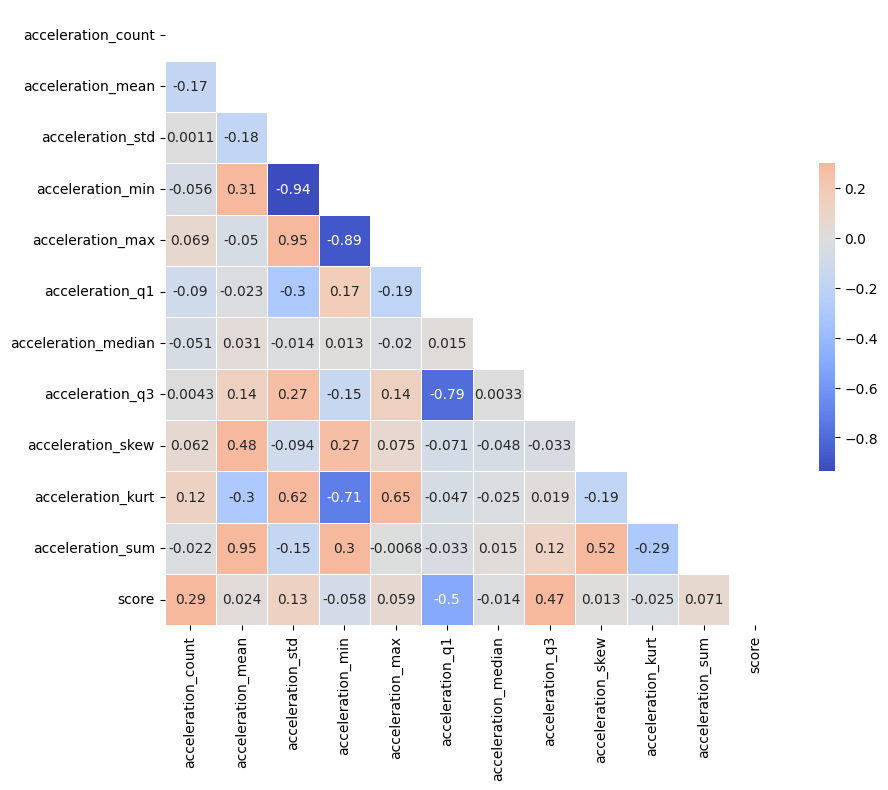

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

df = train_acc.copy()
df = df.merge(train_scores, on='id', how='left')

# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle (optional)
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap='coolwarm', vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

plt.show()

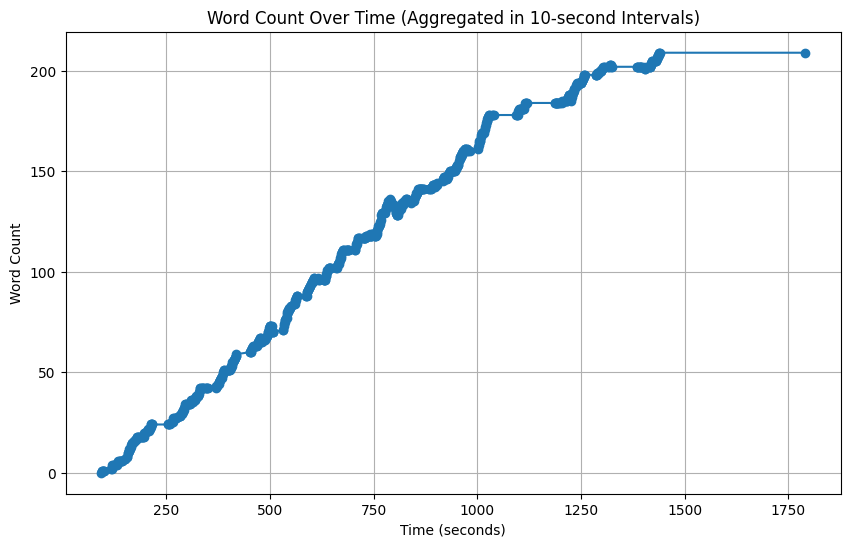

In [33]:
import pandas as pd
import matplotlib.pyplot as plt

time_agg = 1
sample = train_logs[train_logs['id']=='f65da054']

df = sample.copy()
# Convert 'down_time' from milliseconds to seconds
df['down_time_sec'] = df['down_time'] / 1000

# Round down the time to the nearest 10 seconds for aggregation
df['time_bin'] = df['down_time_sec'].apply(lambda x: time_agg * (x // time_agg))

# Group by the new time bins and sum the word counts
word_count_agg = df.groupby('time_bin')['word_count'].max()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(word_count_agg.index, word_count_agg.values, marker='o')
plt.title('Word Count Over Time (Aggregated in 10-second Intervals)')
plt.xlabel('Time (seconds)')
plt.ylabel('Word Count')
plt.grid(True)
plt.show()

In [8]:
df

,id,event_id,down_time,up_time,action_time,activity,down_event,up_event,text_change,cursor_position,word_count,down_time_sec,time_bin
0,001519c8,1,4526,4557,31,Nonproduction,Leftclick,Leftclick,NoChange,0,0,4.526,0.0
1,001519c8,2,4558,4962,404,Nonproduction,Leftclick,Leftclick,NoChange,0,0,4.558,0.0
2,001519c8,3,106571,106571,0,Nonproduction,Shift,Shift,NoChange,0,0,106.571,100.0
3,001519c8,4,106686,106777,91,Input,q,q,q,1,1,106.686,100.0
4,001519c8,5,107196,107323,127,Input,q,q,q,2,1,107.196,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2552,001519c8,2553,1781786,1781841,55,Remove/Cut,Backspace,Backspace,q,555,255,1781.786,1780.0
2553,001519c8,2554,1781917,1781991,74,Remove/Cut,Backspace,Backspace,q,554,255,1781.917,1780.0
2554,001519c8,2555,1782062,1782141,79,Remove/Cut,Backspace,Backspace,q,553,255,1782.062,1780.0
2555,001519c8,2556,1782922,1782985,63,Input,q,q,q,554,255,1782.922,1780.0


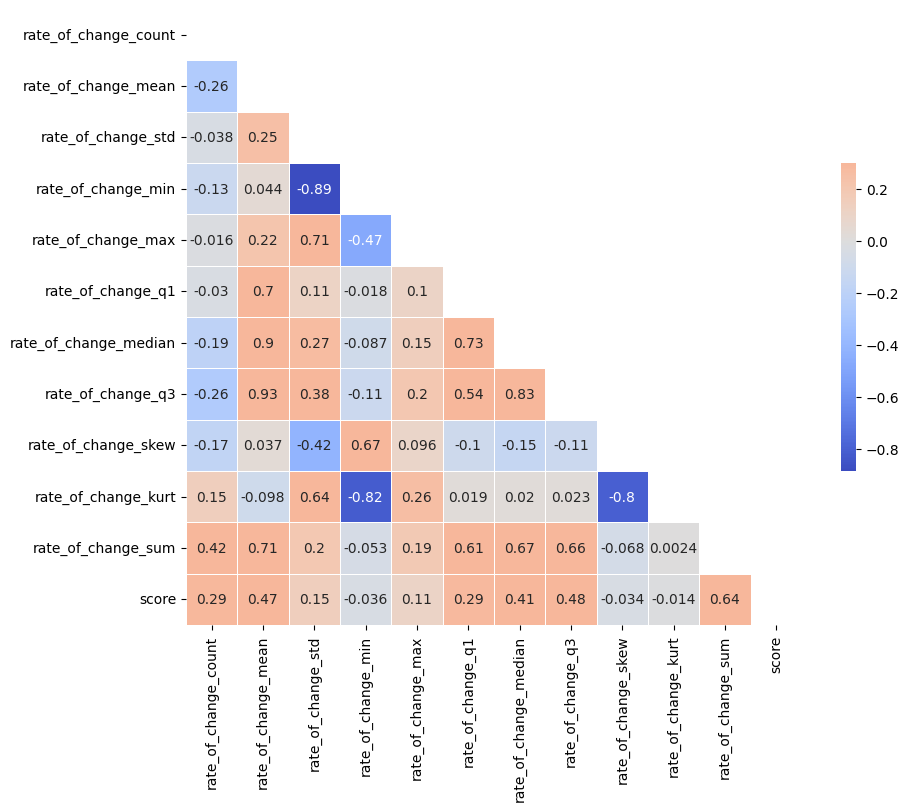

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

df = train_roc.copy()
df = df.merge(train_scores, on='id', how='left')

# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle (optional)
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap='coolwarm', vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

plt.show()